In [1]:
from sage.all import *
import building_vertex
from utils import *
import pickle
from indices_perp_mapping import create_neighbors_dict_indices
import itertools
from multiprocessing import Pool, cpu_count
import numpy as np
import cupy as cp
from math import cos, sin, pi, hypot
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
%load_ext autoreload
%autoreload 2

#### $ E=\mathbb{Q}[x]/(x^2+2) $
$ E_7=\mathbb{Q}_7[x]/(x^2+2) $

$T = \sqrt{-2} \in E$ 

$t = \sqrt{-2} \in E_7$

In [2]:
p = 7
poly = x^2+2
Q_p = Qp(p,print_mode='bars',prec=50)
Ep.<t> = Q_p.extension(poly)
E.<T> = QQ.extension(poly)

uniformizer = p 

p_val = lambda a: Ep(a).valuation()
p_norm = lambda a: uniformizer ** -p_val(a)

def approximate_E(a):
    digit_to_remove =uniformizer^(Ep.precision_cap()-5)
    return E(Ep(a) % digit_to_remove% digit_to_remove)
    

def get_rep(M):
    rep =  building_vertex.get_rep(M,Ep,E,p_val,p_norm)
    converted =  building_vertex.convert_matrix(rep,approximate_E)
    return set_im(converted)


In [3]:
# J = Matrix([[0,0,1],[0,1,0],[1,0,0]])

involution = lambda M:get_rep((get_rep(M).C.T)^-1)
pair = lambda a: (a,involution(a))
act_on_pair = lambda g,pair: (get_rep(g*pair[0]),get_rep(g*pair[1]))


def length(g):
    d = g.nrows()
    p_vals = [p_val(g[i,j]) for i in range(d) for j in range(d)]
    return p_val(det(g)) - d*min(p_vals)
                          
dist = lambda g: (length(g)+length(g^-1))//g.nrows()

def div_min_val(M):
    minval = min(p_val(M[i,j]) for i in range(M.nrows()) for j in range(M.ncols()))
    return set_im(M/(uniformizer^minval))

def get_det_1(A):
    d = A.nrows()
    k = p_val(det(A))
    j = uniformizer^(k/d)
    return A/j

def matrix_order(M,N=100,projected=True):
    if projected:
        M = get_det_1(M)
    for i in range(1,N):
        if M**i==Id:
            return i
    return infinity

In [4]:
def E_iter(n=p, with_negatives = False):
    nrange = range(-n,n) if with_negatives else range(n)
    for a, b in itertools.product(nrange,repeat=2):
        yield a + b * T

def check_triplet(args):
    a, b, c, x, y, z = args
    M = Matrix(3, [a, x, y,
                   0, b, z,
                   0, 0, c])
    rep = get_rep(M)
    rep.set_immutable()
    if dist(rep) == 1:
        return rep
    return None

def create_neighbors_parallel():
    neighbors = set() 
    args_list = []
    
    for a, b, c in itertools.product([1, uniformizer], repeat=3):
        E_a = list(E_iter(a))
        E_b = list(E_iter(b))
        for x in E_a:
            for y in E_a:
                for z in E_b:
                    args_list.append((a, b, c, x, y, z))
    
    with Pool(cpu_count()) as pool:
        results = pool.map(check_triplet, args_list)
    # results = [check_triplet(args) for args in args_list]
    for r in results:
        if r is not None:
            neighbors.add(r)
    return neighbors

neighbors = create_neighbors_parallel()
len(neighbors)

4902

In [5]:
def are_neighbors(A,B):
    """
    if exists N in neighbors s.t. AK=BNK or ANK=BK
    equivalently B^-1A in NK or A^-1B in NK <=> dist(B^-1A)=1 or dist(A^-1B)=1
    """
    return dist(B^-1*A)==1 or dist(A^-1*B)==1
    # for n in neighbors:
    #     if get_rep(A) == get_rep(B*n) or  get_rep(B) == get_rep(A*n):
    #         return True
    # return False

def flipped_edge(A):
    """
    check if (A, involution(A)) is an edge in the building (and therefore flipped by the action of #)
    """
    return are_neighbors(A,involution(A))

def is_fixed_point(A):
    return get_rep(A) == get_rep(involution(A))
    
fedges = [n for n in neighbors if flipped_edge(n) and length(n)==1]

In [6]:
len(fedges)

344

In [7]:
from stabilizer import get_stab as s_get_stab
get_stab = lambda g : s_get_stab(g,E,uniformizer)


In [ ]:
for v in fedges:
    stab = get_stab(v)

In [9]:
def get_flipped_edge(k,n):
    kn = k*n
    rep, inv= get_rep(k*n),get_rep(involution(k*n))
    if flipped_edge(kn) and length(kn)<=length(inv):
        return rep,inv
    return None

def get_fixed_point(pair,n):
    point = get_rep(pair[0]*n) 
    if is_fixed_point(point):
        return point
    return None

def build_tree(depth=0,root=Id,neighbors=neighbors,starting_level=0):
    """
    build neighbors list for the tree, up to given depth 
    """
    level_fixed_points = [root] if starting_level%2==0 else []
    level_flipped_egdes = [] if starting_level%2==0 else [(root,involution(root))]
    vertices_list = {}
    
    for i in range(depth):
        if (i + starting_level %2)==0: # even levels
            #add flipped edges:
            new_values = {k:list(filter(None,[get_flipped_edge(k,n) for n in neighbors])) 
                          for k in level_fixed_points}
            level_flipped_egdes = [pair  for pair_list in new_values.values() for pair in pair_list]

        else: # odd levels
            #add fix points
            new_values ={pair:list(filter(None,[get_fixed_point(pair,n) for n in neighbors])) for pair in level_flipped_egdes}
            level_fixed_points = [fpoint for flist in new_values.values() for fpoint in flist]
        vertices_list.update(new_values)
            
    return vertices_list

In [10]:
def radial_tree_positions(G, root, step=1.3):
    """
    Return {vertex: (x,y)} with root at (0,0) and each root-branch in its own sector.
    step = radial distance per depth.
    """
    # Build rooted children dict (BFS)
    parent = {root: None}
    order  = [root]
    children = {}
    for u in order:
        kids = []
        for v in G.neighbors(u):
            if v not in parent:
                parent[v] = u
                kids.append(v)
                order.append(v)
        children[u] = kids

    # Handle degenerate tree
    if not children[root]:
        return {root: (0.0, 0.0)}

    # Subtree sizes (to space nodes proportionally inside each sector)
    size = {u: 1 for u in order}
    for u in reversed(order):
        for v in children[u]:
            size[u] += size[v]

    pos = {root: (0.0, 0.0)}

    def lay(u, a0, a1, depth):
        if a1 <= a0:
            return
        am = 0.5 * (a0 + a1)
        r  = depth * step
        pos[u] = (r * cos(am), r * sin(am))
        tot = sum(size[v] for v in children[u])
        a = a0
        for v in children[u]:
            span = (a1 - a0) * (size[v] / tot) if tot else 0
            lay(v, a, a + span, depth + 1)
            a += span

    # Split full circle equally among root's children (different directions)
    k = len(children[root])
    for i, v in enumerate(children[root]):
        a0 = 2 * pi * i / k
        a1 = 2 * pi * (i + 1) / k
        lay(v, a0, a1, 1)

    return pos


def two_mat_to_str(A,B):
    ret_val = ''
    for rowA , rowB in zip(A,B):
        ret_val+= str(list(rowA)) + '    '  + str(list(rowB)) + '\n'
    return ret_val

def label_func(v):
    if type(v) == tuple:
        return two_mat_to_str(v[0],v[1])
    return str(v)   

def color_by_dist(v):
    if type(v) == tuple:
        return dist(v[0])
    return dist(v)


def numeric_to_color_classes(vals, cmap_name='viridis'):
    lo, hi = min(vals.values()), max(vals.values())
    if hi == lo: hi = lo + 1.0
    cmap = get_cmap(cmap_name)
    color_classes = {}
    for v, x in vals.items():
        t = (x - lo) / (hi - lo)
        color_classes.setdefault(to_hex(cmap(t)), []).append(v)
    return color_classes

In [ ]:
file_name = "PGU_3_Q7_tree.pkl"

build = True

if build:
    tree = build_tree(2)
    # Save
    with open(file_name, "wb") as f:
        pickle.dump(tree, f)
else:
    # Load
    with open(file_name, "rb") as f:
        tree = pickle.load(f)
        
graph = Graph(tree)

In [ ]:
# labels = {v: label_func(v) for v in graph.vertices()}
labels = {v: '' for v in graph.vertices()}

vcolors = numeric_to_color_classes({v: color_by_dist(v) for v in graph.vertices()}, cmap_name='magma')
pos = radial_tree_positions(graph, root=Id, step=1.6)

graph.show(pos=pos, vertex_labels=labels, vertex_size=70,vertex_colors = vcolors,figsize=(26,50))


# Action of $GU_3(\mathbb{Z}[\sqrt{-2},\frac{1}{7}])$ on the tree
## $GU_3(\mathbb{Z}[\sqrt{-2},\frac{1}{7}]) = \left\{ A\in M_{3}\left(\mathbb{Z}\left[\sqrt{-2},\frac{1}{7}\right]\right)\mid AA^{*}=7^{i}I\right\} $

In [ ]:
def create_norms_dict(n=1,with_negatives=True):
    """
    iterate all a+bT |a|,|b|<=n and map it by norm
    """
    norms_dict = {}
    for x in E_iter(n+1,with_negatives=with_negatives):
        k = norm(x)
        if k not in norms_dict.keys():
            norms_dict[k]=[]
        norms_dict[k].append(x)
    return norms_dict

def get_norm_vector(n,norms_dict=None):
    """
    return all the vectors of norm n
    """
    if norms_dict is None:
        norms_dict=create_norms_dict(n)
    
    keys = [a for a in norms_dict.keys() if a <= n]
    vectors = []
    for a,b in itertools.product(keys,repeat=2):
        c = n-a-b
        if c>=0 and c in keys:
            for x,y,z in itertools.product(norms_dict[a],norms_dict[b],norms_dict[c]):
                vectors.append((x,y,z))
    return vectors

def perp(v1,v2):
    return sum(v1[i]*v2[i].conjugate() for i in range(len(v1))) == 0

def create_perp_graph(n_vectors):
    """
    build a graph which its vertices are vectors of norm n, and edges connect each pair of vectors which perpendicular to each other.
    """
    return {v:{u for u in n_vectors if perp(u,v)} for v in n_vectors}

def find_GU(n=1,n_vectors=None,n_graph=None):
    if n_vectors is None:
        n_vectors = get_norm_vector(n)
    if n_graph is None:
        n_graph = create_perp_graph(n_vectors)
    unitaries = set()
    prep_couples = [(v1,v2) for v1 in n_vectors for v2 in n_graph[v1]]
    for v1,v2 in prep_couples:
        common_perps = n_graph[v1]&n_graph[v2]
        for v3 in common_perps:
            U = set_im(div_min_val(Matrix([v1,v2,v3])))
            unitaries.add(U)
    return unitaries

In [13]:
def E_to_Z(x):
    """
    get
    x = a + b*T
    returns [a,b]
    """
    poly = x.polynomial()
    return [poly[0],poly[1]]

def vec_E_to_Z(v):
    return [E_to_Z(x) for x in v]

In [517]:
n = 5^4
norms_dict=create_norms_dict(n)
n_vectors = get_norm_vector(n,norms_dict=norms_dict)
generate_neighbors = False
if generate_neighbors:
    n_vectors_np = [vec_E_to_Z(v) for v in n_vectors]
    # len(n_vectors_np)

In [15]:
all_perp_dict_filename = 'all_perp_dict.pkl'

if generate_neighbors:
    X_batch_size = 8_280
    Y_batch_size = 17_280 #should be 17_280 in both
    perp_dict = create_neighbors_dict_indices(n_vectors_np,X_batch_size,Y_batch_size)
    # Dump to a file using pickle
    with open(all_perp_dict_filename, "wb") as f:
        pickle.dump(perp_dict, f)
else:
    with open(all_perp_dict_filename, "rb") as f:
        perp_dict = pickle.load(f)


### get orbits

In [60]:
file_name = "GU25.pkl"

generate_unitaries_25 = False

if generate_unitaries_25:
    unitaries_25 = find_GU(25)
else:
    with open(file_name, "rb") as f:
        unitaries_25 = pickle.load(f)

len(unitaries_25)

21072

In [61]:
graph_vertices = set(graph.vertices())

# --- globals visible in worker processes ---
V = None          # the matrix 'v' to multiply on the right
PAIR = False      # whether to return (get_rep(uv), get_rep(involution(uv)))
GV = None         # optional: graph_vertices to filter in-worker

def _init_worker(v, pair, graph_vertices=None):
    global V, PAIR, GV
    V, PAIR, GV = v, pair, graph_vertices

def _apply(u):
    uv = u * V
    out = (get_rep(uv), get_rep(involution(uv))) if PAIR else get_rep(uv)
    if GV is None:
        return out
    return out if out in GV else None

def get_orbit(v, unitaries, pair=False, graph_vertices=graph_vertices,
              processes=None, chunksize=256):
    with Pool(processes or cpu_count(),
              initializer=_init_worker,
              initargs=(v, pair, graph_vertices)) as pool:
        results = pool.map(_apply, unitaries, chunksize=chunksize)
    # filter out Nones if we did membership in-worker
    return {r for r in results if r is not None} if graph_vertices is not None else set(results)


In [62]:

v1 = Matrix(3,[1,0,0,
              0,5,2,
              0,0,1])

v2= Matrix(3,[5,1,4*T + 1,
              0,1,0,
              0,0,1])

v3 = Matrix(3,[5,T,3*T + 2,
              0,1,0,
              0,0,1])

v4 = Matrix(3,[5,T+1,4*T + 3,
              0,1,0,
              0,0,1])

v5 = Matrix(3,[5,1,2*T,
              0,1,0,
              0,0,1])

v6 =  Matrix(3,[25,5*T,11*T+4,
                0,5,4*T+3,
                0,0,1])

# v7 =  Matrix(3,[25,5*T,7*T+5,
#                 0,5,1,
#                 0,0,1])

# v8 = Matrix(3,[25,5*T,23*T+5,
#                 0,5,4,
#                 0,0,1])

# v9 = Matrix(3,[25,5,12*T+8,
#                 0,5,3*T+2,
#                 0,0,1])

In [63]:
v1_orbit = get_orbit(v1,unitaries_25,pair=True,graph_vertices=None)
v2_orbit = get_orbit(v2,unitaries_25,pair=True,graph_vertices=None)
v3_orbit = get_orbit(v3,unitaries_25,pair=True,graph_vertices=None)
v4_orbit = get_orbit(v4,unitaries_25,pair=True,graph_vertices=None)
v5_orbit = get_orbit(v5,unitaries_25,pair=True,graph_vertices=None)


In [ ]:
v0_orbit = get_orbit(Id,unitaries_25,graph_vertices=None)

v6_orbit = get_orbit(v6,unitaries_25,graph_vertices=None)
# v7_orbit = get_orbit(v7,unitaries_25,graph_vertices=None)
# v8_orbit = get_orbit(v8,unitaries_25,graph_vertices=None)
# v9_orbit = get_orbit(v9,unitaries_25,graph_vertices=None)

rest_orbits = [v6_orbit,
               v7_orbit,
               v8_orbit,
               v9_orbit]
rest_orbits = [{r for r in orbit if dist(r)==2} for orbit in rest_orbits]
rest_reps = [v6,v7,v8,v9]

In [21]:
(len(v1_orbit&graph_vertices),len(v2_orbit&graph_vertices),len(v3_orbit&graph_vertices),len(v4_orbit&graph_vertices),len(v5_orbit&graph_vertices))

(18, 24, 48, 24, 12)

In [22]:
len(v0_orbit),len(v6_orbit),len(v7_orbit),len(v8_orbit),len(v9_orbit)

(439, 10536, 5268, 5268, 5268)

### iterate over length 4 unitaries

In [1198]:
# restart = True
if restart:
    def perps_iter(perp_dict, first_i1=0):
        keys = np.array(list(perp_dict.keys()))
        keys.sort()
        first_idx= (keys>=first_i1).argmax() # the first index which its value >= i1
        for i1 in keys[first_idx:]:
            for i2 in perp_dict[i1]:
                common_perps = perp_dict[i1]&perp_dict[i2]
                for i3 in common_perps:
                    U = set_im(div_min_val(Matrix([n_vectors[i1],n_vectors[i2],n_vectors[i3]])))
                    yield U
    
    piter = perps_iter(perp_dict)
    new_unitaries = []
    restert=False

In [ ]:
for U in piter:
    if dist(U)==4:
        for j,v in zip(range(6,10),rest_reps):
            Uv = get_rep(U*v)
            for i, orbit in zip(range(6,10),rest_orbits):
                 if Uv in orbit: # and i!=j:
                    new_unitaries.append(U)
                    print_mat(U)
                    print(f'sends v{j} to orbit {i}')  
                    continue


In [1247]:
len(new_unitaries)

5200

In [1248]:
all_new_uni625 = {set_im(s*u) for s in v0_stab for u in new_unitaries[5200:]}
len(all_new_uni625)

6432

#### extend orbits

In [ ]:
v1_orbit |= get_orbit(v1,all_new_uni625,pair=True,graph_vertices=None)
v2_orbit |= get_orbit(v2,all_new_uni625,pair=True,graph_vertices=None)
v3_orbit |= get_orbit(v3,all_new_uni625,pair=True,graph_vertices=None)
v4_orbit |= get_orbit(v4,all_new_uni625,pair=True,graph_vertices=None)
v5_orbit |= get_orbit(v5,all_new_uni625,pair=True,graph_vertices=None)

In [25]:
rest_orbits_s1 = [ v1_orbit,
                   v2_orbit,
                   v3_orbit,
                   v4_orbit,
                   v5_orbit]
# rest_orbits = [{r for r in orbit if dist(r)==2} for orbit in rest_orbits]
rest_reps_s1 = [v1,v2,v3,v4,v5]

In [1250]:
len_s3_orbit = lambda orbit: len(list(filter(lambda a:dist(a[0])==3,orbit)))
reachable_s3_sizes = list(map(len_s3_orbit, rest_orbits_s1))
reachable_s3_sizes

[2598, 6684, 12840, 10392, 5244]

In [1208]:
sum(reachable_s3_sizes), 126*5*125

(34398, 78750)

In [380]:
reachable_s3_sizes

[2598, 9228, 10440, 10392, 5244]

In [30]:
A9_7 = Matrix([[ -6*T + 4, -14*T + 1, -12],
                [ -T + 7, 6*T + 8, 13*T - 10],
                [ 9*T - 18, -4*T + 8, 3*T - 5]])

A7_6 = Matrix([[ 4, 6*T, 16*T + 5],
                [ -T + 5, -5*T - 22, 8],
                [ 17*T + 2, 3*T - 1, -2*T + 4]])

A6_8 = Matrix([[ 3*T - 1, T - 14, 2*T + 20],
                [ -6*T - 6, 11*T - 12, 5*T - 9],
                [ 11*T + 16, 4*T - 3, 5*T - 6]])

A8_9 = Matrix([[ 4*T + 5, -5*T - 2, -15*T - 8],
                [ T - 20, -5*T - 13, -2],
                [ -9*T - 2, 12*T - 8, -7*T + 3]])

get_rep(A9_7*v9) == v7, get_rep(A7_6*v7) == v6,get_rep(A6_8*v6)==v8,get_rep(A8_9*v8)==v9

(True, True, True, True)

### plot graph

In [ ]:
v6_orbit |=v7_orbit|v8_orbit|v9_orbit

In [198]:
all_orbits = (v0_orbit | v1_orbit |v2_orbit| v3_orbit| v4_orbit| v5_orbit |
                                v6_orbit)
rest = graph_vertices - all_orbits
len(rest)

96

In [ ]:
# Pick your colors and plot
vc = {
    'tab:blue':   list(v0_orbit),
    'tab:orange': list(v1_orbit&graph_vertices),
    'tab:green':  list(v2_orbit&graph_vertices),
    'red': list(v3_orbit&graph_vertices),
    'yellow':list(v4_orbit&graph_vertices),
    'tab:pink':list(v5_orbit&graph_vertices),
    'purple':list(v6_orbit),
    # 'lime':list(v7_orbit),
    # 'brown':list(v8_orbit),
    # 'fuchsia':list(v9_orbit),
    'lightgray':  list(rest)   
}


# labels = {v: label_func(v) for v in graph.vertices()}
labels = {v: '' for v in graph.vertices()}

pos = radial_tree_positions(graph, root=Id, step=1.6)

graph.show(pos=pos, vertex_labels=labels, vertex_size=200,vertex_colors = vc,figsize=(15,50))

In [ ]:
selected_vretices = [(set_im(v),set_im(involution(v))) for v in [v1,v2,v3,v4,v5]]  #+[set_im(v) for v in [v6,v7,v8,v9,v10]]
small_tree = {v: tree[v] for v in selected_vretices}
small_tree[Id] = selected_vretices
small_graph = Graph(small_tree)

In [198]:
# leaves = {v for nbrs in small_tree.values() for v in nbrs if v not in small_tree.keys()}
# third_sphere = {v:list(filter(None,[get_flipped_edge(v,n) for n in neighbors])) 
#                           for v in leaves}     
# small_tree |= third_sphere
#small_graph = Graph(small_tree)

In [ ]:
small_graph_vertices = set(small_graph.vertices())

rest_small = small_graph_vertices - all_orbits


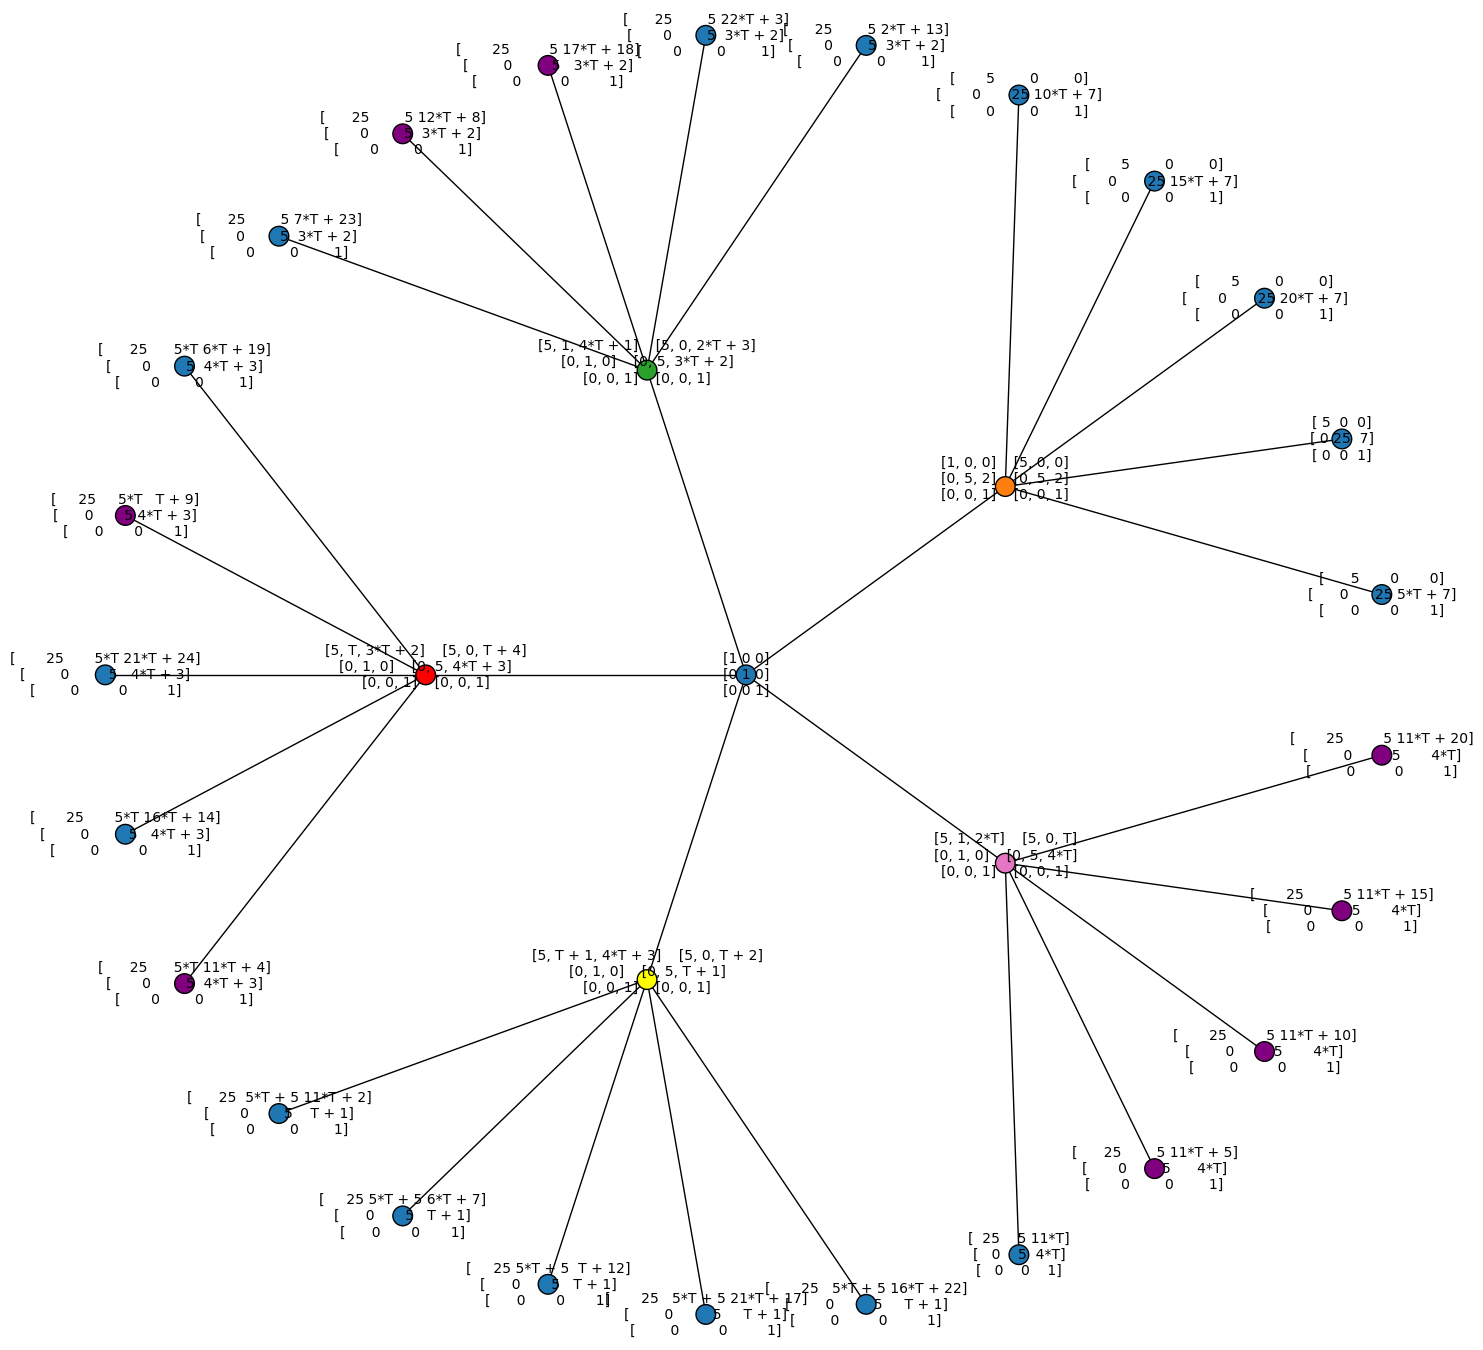

In [33]:
small_graph_vertices = set(small_graph.vertices())

rest = small_graph_vertices - all_orbits

# Pick your colors and plot
vc = {
    'tab:blue':   list(v0_orbit & small_graph_vertices),
    'tab:orange': list(v1_orbit & small_graph_vertices),
    'tab:green':  list(v2_orbit & small_graph_vertices),
    'red': list(v3_orbit & small_graph_vertices),
    'yellow':list(v4_orbit & small_graph_vertices),
    'tab:pink':list(v5_orbit & small_graph_vertices),
    'purple':list(v6_orbit & small_graph_vertices),
                  
    'lightgray':  list(rest_small)   
}


labels = {v: label_func(v) for v in graph.vertices()}
# labels = {v: '' for v in small_graph_vertices}

pos = radial_tree_positions(small_graph, root=Id, step=1.6)

small_graph.show(pos=pos, vertex_labels=labels, vertex_size=200,vertex_colors = vc,figsize=(15,50))

#### sizes of the reachable orbits

In [289]:
18*5*17+348*18

7794

In [290]:
24*3*23+366*24

10440

In [292]:
48*3*47+294*48

20880

In [293]:
24*5*23+318*24

10392

In [295]:
12*11+426*12

5244

In [296]:
7794+10440+20880+10392+5244

54750

In [299]:
126*5*125

78750

In [282]:
18*5+24*3+48*3+24*5+12

438

In [283]:
24*2+48*2+12*4

192

In [279]:
len_s1_orbit = lambda orbit: len(list(filter(lambda a:dist(a[0])==1,orbit)))
reachable_s1_sizes = list(map(len_s1_orbit, rest_orbits_s1))
reachable_s1_sizes

[18, 24, 48, 24, 12]

#### solutions for the unitary system

$$ h^{*}h=2^{\ell}I $$
$$ h\in gKg^{-1} $$
$$ \tilde{h}=g^{-1}hg\in K=GL_{3}\left(\mathbb{Z}_{5}\left[\sqrt{-2}\right]\right) $$
$$ \left(g\tilde{h}g^{-1}\right)^{*}g\tilde{h}g^{-1}=5^{\ell}I $$
$$ \left(g^{*}\right)^{-1}\tilde{h}^{*}g^{*}g\tilde{h}g^{-1}=5^{\ell}I $$
$$ \tilde{h}^{*}g^{*}g\tilde{h}=5^{\ell}g^{*}g $$


lets find $g$ which is unitarian in $ \mathbb{Q}_p$

In [1624]:
# QI.<I> = QuadraticField(-1)
# L.<T>= QI.extension(x^2+2)
# sigma = L.automorphisms()[1] # T -> -T automorphism
# conj_Ep = sigma

In [ ]:
j = Ep(x^2+1).roots()

In [ ]:
J = Matrix(3,[0,0,1,
              0,1,0,
              1,0,0])

Hs = Matrix(3,[1,j,0,
              0,0,t,
              1,-j,0])/t
def conj_Ep(a):
    poly = Ep(a).polynomial()
    a,b = poly[0],poly[1]
    return a - b*t
    
def conj_mat(A):
    return Matrix([[conj_Ep(a) for a in row] for row in A]).T

H = conj_mat(Hs)

In [ ]:
found = []
b=0
for a in E_iter(5):
# for b in range(25):
    a_s = conj_Ep(a)
    A = Matrix(3, [25,5*a,-a*a_s/2+b*T,
                  0,5,-a_s,
                  0,0,1])
    # print( A.C.T*J*A)
    AA = H*A*H^-1
    print(b,get_rep(AA) in v0_orbit)
    if get_rep(AA) not in v0_orbit:
        print_mat(AA)
        found.append(AA)
        raise Exception()


In [651]:
A = diag(1,5,25)
AA = H*convert_matrix(A,Ep)*Hs
get_rep(AA) in v0_orbit

NameError: name 'H' is not defined

In [1566]:
convert_matrix(AA,E)

[                                                                    7*T + 51/4 166389389362385279/55319158405442879*T + 122146567877192027/205563712822942831                                                                          5/2*T]
[-166389389362385279/55319158405442879*T - 125169966899588521/58863953010451679                                                                     7*T - 53/4                                       -692029372750606790/110422359737857437*T]
[                                                                         1/2*T                                        138405874550121358/110422359737857437*T                                                                              5]

In [1491]:
AA=found[0]
convert_matrix(conj_mat(AA)*AA,E)

[25  0  0]
[ 0 25  0]
[ 0  0 25]

In [1437]:
filtered = list(filter(lambda a: dist(AA * convert_matrix(a,Ep) *AA^-1) <= 2 , unitaries_25))

In [1475]:
def unitary_cond_Ep(a):
    CC=(AA * convert_matrix(a,Ep) * AA^-1)
    return get_rep(CC*convert_matrix(v6,Ep))==v6

equation_stab = list(filter(unitary_cond_Ep , unitaries_25))

In [ ]:
[(convert_matrix(AA * convert_matrix(a,Ep) * AA^-1,E)) for a in equation_stab]

In [506]:
w1

[       125 55*T + 100  61*T + 79]
[         0          5    4*T + 3]
[         0          0          1]

In [507]:
Jw1 = div_min_val(w1.C.T*w1)
Jw1

[         625  275*T + 500  305*T + 395]
[-275*T + 500          643   71*T + 585]
[-305*T + 395  -71*T + 585          549]

In [632]:
U1 = Matrix(E,3,[1,0,0,
                 0,1,-1,
                 0,0,1])

U2 = Matrix(E,3,[1,0,0,
                 0,1,0,
                 0,3*T,1])

U3 = Matrix(E,3,[1,T-1,0,
                 0,1,0,
                 0,0,1])

U4 = Matrix(E,3,[1,0,-2,
                 0,1,0,
                 0,0,1])

U5 = Matrix(E,3,[1,0,0,
                 0,1,0,
                 0,-2,1])

U6 = Matrix(E,3,[1,0,1,
                 0,1,0,
                 0,0,1])

U7 = Matrix(E,3,[1,0,0,
                 0,1,0,
                 T,0,1])

U8 = Matrix(E,3,[1,0,2-T,
                 0,1,2-2*T,
                 0,0,1])


U9 = Matrix(E,3,[1,1,0,
                 0,1,0,
                 0,0,1])


U = U9* U8 * U7 * U6 * U5 * U4 * U3 * U2 * U1 
W1 = U.C.T
Bw1 = W1.C.T*Jw1*W1

Bw1

[      10 -5*T + 5        0]
[ 5*T + 5       10        0]
[       0        0        1]

In [681]:
iter_2 = E_iter(4,with_negatives=True)

In [682]:
vectors_1 = []
vectors_10 = []

for a,b,c in itertools.product(iter_2,repeat=3):
    v=Matrix([[a],[b],[c]])
    vsBw1v = v.C.T*Bw1*v
    if vsBw1v==10:
        vectors_10.append(v)
    if vsBw1v==1:
        vectors_1.append(v)


In [685]:
solutions_Bw1=[]
for v0 in vectors_10:
    for v1 in vectors_10:
        if v0.C.T*Bw1*v1==Bw1[0,1]:
            for v2 in vectors_1:
                if v0.C.T*Bw1*v2==Bw1[0,2] and v1.C.T*Bw1*v2==Bw1[1,2]:
                    sol = Matrix([list(v0.T)[0],list(v1.T)[0],list(v2.T)[0]]).T
                    solutions_Bw1.append(sol)

In [686]:
Jw1_solutions = [W*sol*W^-1 for sol in solutions_Bw1]
stab_w1 = {set_im(div_min_val(w1*A*w1^-1)) for A in Jw1_solutions}

### v6 orbit neighbors

In [25]:
v6_tree = build_tree(depth=1, root= set_im(v6))

In [33]:
v6_tree_orbits = []

cur_neighbors = set(v6_tree[v6])
while cur_neighbors:
    n = list(cur_neighbors)[0]
    new_orbit = {act_on_pair(g,n) for g in v6_stab}
    v6_tree_orbits.append(new_orbit)
    cur_neighbors -= new_orbit

In [34]:
[len(o) for o in v6_tree_orbits] 

[24, 24, 48, 6, 24]

In [65]:
w0 = Matrix([[ 125, 5*T + 25, 11*T + 79],
                [ 0, 5, 4*T + 3],
                [ 0, 0, 1]])

w1 = Matrix([[ 125, 55*T + 100, 61*T + 79],
            [ 0, 5, 4*T + 3],
            [ 0, 0, 1]])


In [ ]:
full_w0_orbit = get_orbit(w0,unitaries_25,pair=True,graph_vertices=None)
full_w1_orbit = get_orbit(w1,unitaries_25,pair=True,graph_vertices=None)

In [37]:
w0_orbit, w1_orbit = v6_tree_orbits[0],v6_tree_orbits[3]

In [1371]:
pp_iter = perps_iter(perp_dict)

In [1358]:
apply_on_pair= lambda g,pair: (get_rep(g*pair[0]),get_rep(g*pair[1]))
s1_orbits = [orbit&graph_vertices for orbit in rest_orbits_s1]
w0_pair = (w0,involution(w0))
w1_pair = (w1,involution(w1))

In [1272]:
[v6N in o for o in v6_tree_orbits]

[False, True, False, False, False]

In [1241]:
[[len(o&orbit) for o in v6_tree_orbits] for orbit in [v2_orbit,v3_orbit,v5_orbit]]

[[0, 0, 0, 0, 7], [0, 0, 16, 0, 0], [0, 0, 0, 0, 0]]

In [1251]:
v_trees = [(v, build_tree(depth=1, root= set_im(v))) for v in small_graph_vertices&v6_orbit]

In [1280]:
# pp_iter = perps_iter(perp_dict)
M = set_im(Matrix([[ 25, 5, 11*T + 20],
                    [ 0, 5, 4*T],
                    [ 0, 0, 1]]))
U = Matrix([[ -16*T - 5, 6*T, -4],
        [ -8, -5*T - 22, T - 5],
        [ 2*T - 4, 3*T - 1, -17*T - 2]]) # sends M to v6

# for U in pp_iter:
#     if get_rep(U*M)==v6:
#         break
get_rep(U*M)==v6

True

In [1270]:
N = [a for a in v_trees[0][1][M] if a in v5_orbit][0]
v6N = get_rep(U*N[0]),get_rep(U*N[1])

In [1253]:
for v,v_tree in v_trees:
    print_mat(v)
    print()
    print([len(set(v_tree[v]) & orbit) for orbit in rest_orbits_s1],flush=True)
    print()
    

[[ 25, 5, 11*T + 20],
[ 0, 5, 4*T],
[ 0, 0, 1]]

[0, 7, 8, 0, 1]

[[ 25, 5, 17*T + 18],
[ 0, 5, 3*T + 2],
[ 0, 0, 1]]

[0, 8, 6, 0, 0]

[[ 25, 5*T, T + 9],
[ 0, 5, 4*T + 3],
[ 0, 0, 1]]

[0, 10, 8, 0, 0]

[[ 25, 5, 11*T + 10],
[ 0, 5, 4*T],
[ 0, 0, 1]]

[0, 3, 20, 0, 1]

[[ 25, 5, 12*T + 8],
[ 0, 5, 3*T + 2],
[ 0, 0, 1]]

[0, 5, 12, 0, 0]

[[ 25, 5, 11*T + 15],
[ 0, 5, 4*T],
[ 0, 0, 1]]

[0, 12, 12, 0, 1]

[[ 25, 5, 11*T + 5],
[ 0, 5, 4*T],
[ 0, 0, 1]]

[0, 10, 12, 0, 1]

[[ 25, 5*T, 11*T + 4],
[ 0, 5, 4*T + 3],
[ 0, 0, 1]]

[0, 11, 20, 0, 0]



In [371]:
24*2*23 + (48*2 + 12*4)*24

4560

In [323]:
24*2+12*4

96

In [324]:
24*2+48*25

1248

In [372]:
4560 + 96 + 1248

5904

### w0_tree

In [25]:
pair(w0)

(
[      125  5*T + 25 11*T + 79]  [      125      25*T 96*T + 99]
[        0         5   4*T + 3]  [        0        25 19*T + 13]
[        0         0         1], [        0         0         1]
)

In [39]:
w0_tree = build_tree(depth=1, root= set_im(w0),starting_level=3)

In [22]:
w0_neighbors = set(w0_tree[pair(w0)])

NameError: name 'w0_tree' is not defined

In [72]:
for n in w0_neighbors:
    print(len(get_stab(n)))

96
96
96
48
48
96


In [62]:
w1_tree = build_tree(depth=1, root= set_im(w1),starting_level=3)

In [74]:
w1_neighbors = set(w1_tree[pair(w1)])
for n in w1_neighbors:
    print(len(get_stab(n)))

96
96
96
96
96
96


In [80]:
v = v5
v_tree = build_tree(depth=1, root= set_im(v),starting_level=1)

In [81]:
v_neighbors = set(v_tree[pair(v)])
for n in v_neighbors:
    print(len(get_stab(n)))

48
96
96
48
96
96


## quotient graph

In [26]:
V0= set_im(Id)
V1 = (set_im(v1),set_im(involution(v1)))
V2 = (set_im(v2),set_im(involution(v2))) 
V3 = (set_im(v3),set_im(involution(v3))) 
V4 = (set_im(v4),set_im(involution(v4))) 
V5 = (set_im(v5),set_im(involution(v5))) 
V6 = set_im(v6)
# W0=(set_im(w0),set_im(involution(w0)))
W1=(set_im(w1),set_im(involution(w1)))


factor_graph_adjancy = {V0:[V1,V2,V3,V4,V5],V6:[V2,V3,V5,W1]}
factor_graph = Graph(factor_graph_adjancy)

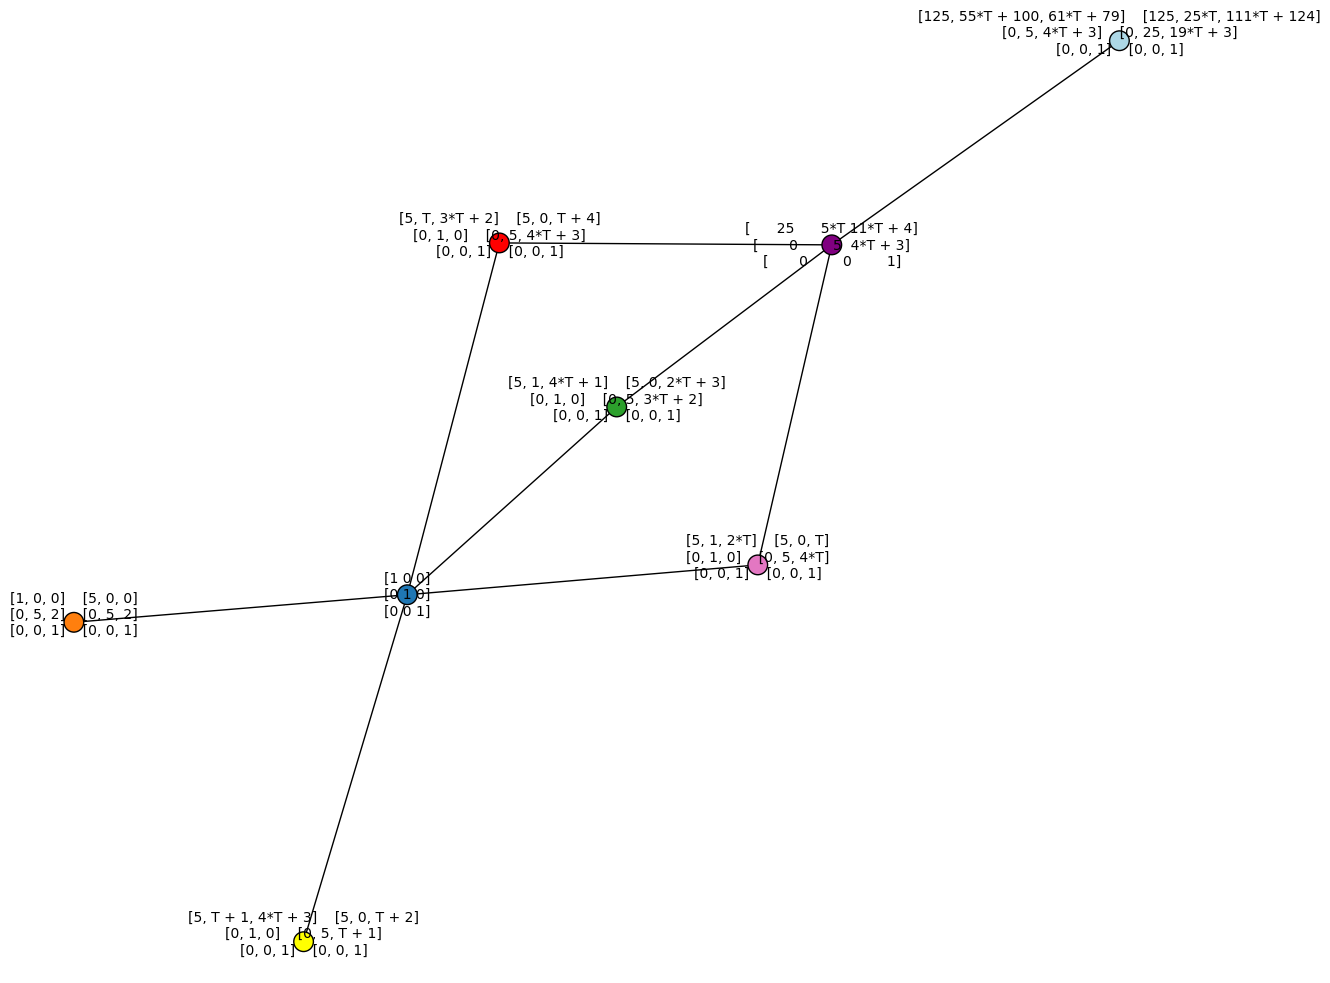

In [27]:
vc = {
    'tab:blue':   [V0],
    'tab:orange': [V1],
    'tab:green':  [V2],
    'red': [V3],
    'yellow':[V4],
    'tab:pink':[V5],
    'purple':[V6],
    'lightblue':[W1],      
    # 'lightgray':  [W0]  
}


labels = {v: label_func(v) for v in factor_graph.vertices()}

factor_graph.show( vertex_labels=labels, vertex_size=200,vertex_colors = vc,figsize=(20,10))

## stabilizers

In [172]:
import pickle
filename = 'unitary_2.pkl'

with open(filename,'rb') as f:
    unitary_2 = pickle.load(f)

In [ ]:
unitary_2

In [140]:
get_rep(U),get_rep(V*U)

(
[       25        20 23*T + 12]  [      25        0 20*T + 7]
[        0         5   3*T + 2]  [       0        5        0]
[        0         0         1], [       0        0        1]
)

In [203]:
M = Matrix([[ T + 5, -T + 2, 2*T + 3],
            [ T + 3, T - 6, -1],
            [ -2*T - 2, -T - 2, 4*T]]
                                )
vM = get_rep(M)
vM

[      25 5*T + 20  4*T + 3]
[       0        5      2*T]
[       0        0        1]

In [231]:
UM = Matrix([[ 1, -T, -3*T - 2],
            [ T - 4, -T + 2, -1],
            [ T - 2, 2*T - 3, -T]])
M6 = div_min_val(UM^-1*M)
print_mat(M6)

[[ 1/2*T, -3*T + 1, -3/2*T - 1],
[ 4, T + 1, -T - 2],
[ 3/2*T + 2, -T + 1, 5/2*T + 1]]


In [243]:
get_rep(M6)

[        625  25*T + 125 596*T + 349]
[          0          25   19*T + 13]
[          0           0           1]

In [216]:
get_rep(M6)

[      25      5*T 11*T + 4]
[       0        5  4*T + 3]
[       0        0        1]

In [ ]:
for U in unitaries_25:
    if get_rep(U*v6)==vM:
        print_mat(U)

In [191]:
get_rep(M)

[        625 100*T + 575 551*T + 550]
[          0          25    2*T + 17]
[          0           0           1]

In [202]:
for U in v4_stab:
    for V in unitary_2:
        VU = V*U
        if get_rep(VU) in v6_orbit:
            print_mat(VU)


[[ T + 5, -T + 2, 2*T + 3],
[ T + 3, T - 6, -1],
[ -2*T - 2, -T - 2, 4*T]]
[[ -T - 5, T - 2, -2*T - 3],
[ -T - 3, -T + 6, 1],
[ -2*T - 2, -T - 2, 4*T]]
[[ T + 5, -T + 2, 2*T + 3],
[ -T - 3, -T + 6, 1],
[ 2*T + 2, T + 2, -4*T]]
[[ -T - 3, -T + 6, 1],
[ T + 5, -T + 2, 2*T + 3],
[ 2*T + 2, T + 2, -4*T]]
[[ T + 3, T - 6, -1],
[ -T - 5, T - 2, -2*T - 3],
[ -2*T - 2, -T - 2, 4*T]]
[[ -T - 5, T - 2, -2*T - 3],
[ T + 3, T - 6, -1],
[ -2*T - 2, -T - 2, 4*T]]
[[ -T - 5, T - 2, -2*T - 3],
[ -T - 3, -T + 6, 1],
[ 2*T + 2, T + 2, -4*T]]
[[ T + 5, -T + 2, 2*T + 3],
[ T + 3, T - 6, -1],
[ 2*T + 2, T + 2, -4*T]]
[[ T + 3, T - 6, -1],
[ T + 5, -T + 2, 2*T + 3],
[ -2*T - 2, -T - 2, 4*T]]
[[ -T - 3, -T + 6, 1],
[ -T - 5, T - 2, -2*T - 3],
[ -2*T - 2, -T - 2, 4*T]]
[[ T + 3, T - 6, -1],
[ -T - 5, T - 2, -2*T - 3],
[ 2*T + 2, T + 2, -4*T]]
[[ -T - 5, T - 2, -2*T - 3],
[ T + 3, T - 6, -1],
[ 2*T + 2, T + 2, -4*T]]
[[ T + 5, -T + 2, 2*T + 3],
[ -T - 3, -T + 6, 1],
[ -2*T - 2, -T - 2, 4*T]]
[[ -T - 3, -T + 6,

In [104]:
A = Matrix(3,[-1,1,0,
             -1,-1,0,
             0,0,T])
unitary_act(A)

[2 0 0]
[0 2 0]
[0 0 2]

In [66]:
from stabilizer import get_stab as s_get_stab
get_stab = lambda g : s_get_stab(g,E,uniformizer)


In [67]:
v0_stab = get_stab(Id)
v6_stab = get_stab(v6)

In [68]:
v1_stab = get_stab(v1)
v2_stab = get_stab(v2)
v3_stab = get_stab(v3)
v4_stab = get_stab(v4)
v5_stab = get_stab(v5)
# w0_stab = get_stab(w0)
w1_stab = get_stab(w1)


In [72]:
make_U= lambda group: list(map(get_det_1,group))
make_PGU= lambda group: list(filter(lambda A: det(A)==1,make_U(group)))

make_group = make_PGU

stablizers = { 'Gv0':make_group(v0_stab),
                'Gv1':make_group(v1_stab),
                'Gv2':make_group(v2_stab),
                'Gv3':make_group(v3_stab),
                'Gv4':make_group(v4_stab),
                'Gv5':make_group(v5_stab),
                # 'Gv6':make_group(v6_stab),              
                # 'Gw1':make_group(w1_stab)
             }

In [75]:
stab = gap.Group(make_group(v6_stab&w1_stab))
print(gap.Order(stab),gap.StructureDescription(stab))


8 C8


In [76]:
make_group(v0_stab&v1_stab)

[
[1 0 0]  [ 1  0  0]  [ 1  0  0]  [ 1  0  0]
[0 1 0]  [ 0  0  1]  [ 0  0 -1]  [ 0 -1  0]
[0 0 1], [ 0 -1  0], [ 0  1  0], [ 0  0 -1]
]

In [167]:
Gv6 = gap.Group(make_PGU(v6_stab))

In [168]:
gap.StructureDescription(Gv6)

GL(2,3)

In [165]:
Gw1 = gap.Group(make_PGU(w1_stab))

In [157]:
gap.StructureDescription(Gw1)

GL(2,3)

In [210]:
ns = small_tree[pair(v2)]
A = [n for n in ns if n in v6_orbit][0]
A_stab = get_stab(A)

In [219]:
make_PGU(A_stab&v2_stab)

[
[1 0 0]  [ 0  1  0]
[0 1 0]  [ 1  0  0]
[0 0 1], [ 0  0 -1]
]

In [220]:
ns = small_tree[pair(v5)]
A = [n for n in ns if n in v6_orbit][0]
A_stab = get_stab(A)

In [163]:
for name, group in stablizers.items():
    stab = gap.Group(group)
    print(name,gap.Order(stab),gap.StructureDescription(stab))
            

Gv0 48 C2 x S4
Gv1 16 C2 x D8
Gv2 8 C2 x C2 x C2
Gv3 4 C2 x C2
Gv4 12 D12
Gv5 8 C2 x C2 x C2


In [161]:
for name, group in stablizers.items():
    stab = gap.Group(group)
    print(name,gap.Order(stab),gap.StructureDescription(stab))


Gv0 24 S4
Gv1 8 D8
Gv2 4 C2 x C2
Gv3 2 C2
Gv4 6 S3
Gv5 4 C2 x C2


In [320]:
file_name = "b_stab_U3(Zsqrtm2_5)_tree.pkl"
with open(file_name, "wb") as f:
    pickle.dump(v6_stab, f)

In [295]:
M=Matrix(3,[-2,T+1,0,
              0,1,0,
              0,0,T])
M_stab = get_stab(M)

In [322]:
file_name = "b_stab_U3(Zsqrtm2_2)_tree.pkl"
with open(file_name, "wb") as f:
    pickle.dump(M_stab, f)

In [199]:
Gv0 = MatrixGroup(list(v0_stab))
Gv6 = MatrixGroup(list(v6_stab))
Gw1 = MatrixGroup(list(w1_stab))


In [252]:
U_mat = v6
UsU = U_mat.H*U_mat


$stab\left(v_{0}\right)$ is all the permutations matrices, but with $\pm 1$ in each coordinate, so 
$$ stab\left(v_{0}\right)\cong S_{3}\ltimes\left(\mathbb{Z}/ 2\mathbb{Z}\right)^{3} $$


In [77]:
def is_subgroup(H):
    return all(set_im(g*h) in H for g,h in itertools.product(H,repeat=2))

def is_normal_subgroup(H,G):
    """
    H <= G
    """
    return all(set_im(g*h*g^-1) in H for g in G for h in H)
    
# is_subgroup(V0_stabilizer)   

In [ ]:
def is_semidirect_product(G,N,H,e=Id):
    """
    for a matrices group G (given as a set of elements)
    check if :
    1. H,N <= G
    2. N is normal in G
    3. H intersect N is {e}
    4. NH = G
    """
    cond1 = is_subgroup(N) and is_subgroup(H)
    cond2 = is_normal_subgroup(N,G)
    cond3 = N&H == {e}
    cond4 = {set_im(n*h) for n in N for h in H} == G
    return cond1 and cond2 and cond3 and cond4
    

In [ ]:
min_entry = lambda M: min(a for row in M for a in row)

S3 = {u for u in V0_stabilizer if min_entry(u)>=0}
H = {set_im(diag(i,j,k)) for i,j,k in itertools.product([-1,1],repeat=3)}

is_semidirect_product(V0_stabilizer,H,S3)

In [ ]:
e0_stab = V0_stabilizer&V1_stabilizer

In [ ]:
permutation_12=Matrix(3,[0 ,1 ,0,
                         1 ,0 ,0,
                         0 ,0 ,1])

In [ ]:
is_semidirect_product(e0_stab,H,{set_im(permutation_12),Id})

$$ stab_{GU_3}\left(e_{0}\right)\cong \left\langle \left(12\right)\right\rangle \ltimes\left(\mathbb{Z}/ 2\mathbb{Z}\right)^{3} $$


The action of $S_3$ is as permutations on $\left(\begin{bmatrix}1\\
 & T & 1\\
 &  & 1
\end{bmatrix},\begin{bmatrix}T &  & 1\\
 & 1\\
 &  & 1
\end{bmatrix},\begin{bmatrix}T & 1\\
 & 1\\
 &  & 1
\end{bmatrix}\right)$

In [ ]:
tree[Id][::-1]

In [ ]:
[(get_rep(permutation_12*a),get_rep(permutation_12*b)) for a,b in tree[Id]][::-1]

In [ ]:
A1 = Matrix(3,[1,1,0,
              1,-1,0,
              0,0,T])

In [ ]:
A1_orbit ={set_im(div_min_val(A1^i)) for i in range(4)}

In [ ]:
is_normal_subgroup(e0_stab,V1_stabilizer)